In [72]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise

from scipy.cluster.hierarchy import dendrogram

DATA_DIR = Path('../data')
PROC_DIR = Path(DATA_DIR / 'original/processed')
OUT_DIR = Path('./out/pca_3d')

if not OUT_DIR.exists():
    Path.mkdir(OUT_DIR)
    

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']

# Helper Functions

In [100]:
def plot_km_results(cluster_count, labels, series):
    plot_count = math.ceil(math.sqrt(cluster_count))
    fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
    fig.suptitle('Clusters')
    row_i=0
    column_j=0
    # For each label there is,
    # plots every series with that label
    for label in set(labels):
        cluster = []
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(series[i],c="gray",alpha=0.4)
                cluster.append(series[i])
        if len(cluster) > 0:
            axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
        axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
        column_j+=1
        if column_j%plot_count == 0:
            row_i+=1
            column_j=0
    plt.tight_layout()
    plt.show()    
    
def plot_unscaled_clusters(labels, nclusters, flows_dict, columns, save_path=None):
    """Plot cluster of the original data (not scaled)"""  
    
    fig, axs = plt.subplots(nrows=nclusters, ncols=len(columns), figsize=(5*len(columns), 5*nclusters))
    for idx, flow in enumerate(flows_dict.values()):
        for col_pos, col in enumerate(columns):
            axs[(labels[idx], col_pos)].plot(flow[col], linewidth=0.5)
            axs[(labels[idx], col_pos)].set(ylabel=col, title=f'Cluster {labels[idx]}')
            
    plt.tight_layout()
    
    if save_path != None:
        plt.savefig(save_path, dpi=200)
    
    plt.show()
    
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    
def scatter_plot_3d(data, save_path=None, c=np.array([]), **kwargs):
    plt.figure(figsize=(10, 10))
    axes = plt.axes(projection='3d')
    scatter = axes.scatter3D(data[:, 0], data[:, 1], data[:, 2], c=c, **kwargs)
    axes.set_xlabel("PC1")
    axes.set_ylabel("PC2")
    plt.tight_layout()
    
    if c.size > 0:
        # produce a legend with the unique colors from the scatter
        legend1 = axes.legend(*scatter.legend_elements(),
                            loc="upper center", title="Classes", mode="expand", ncols=len(set(c)))
        axes.add_artist(legend1)
    
    if save_path != None:
        plt.savefig(save_path, dpi=200)
    
    

# Load data

In [3]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, skiprows=2, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])
        
    

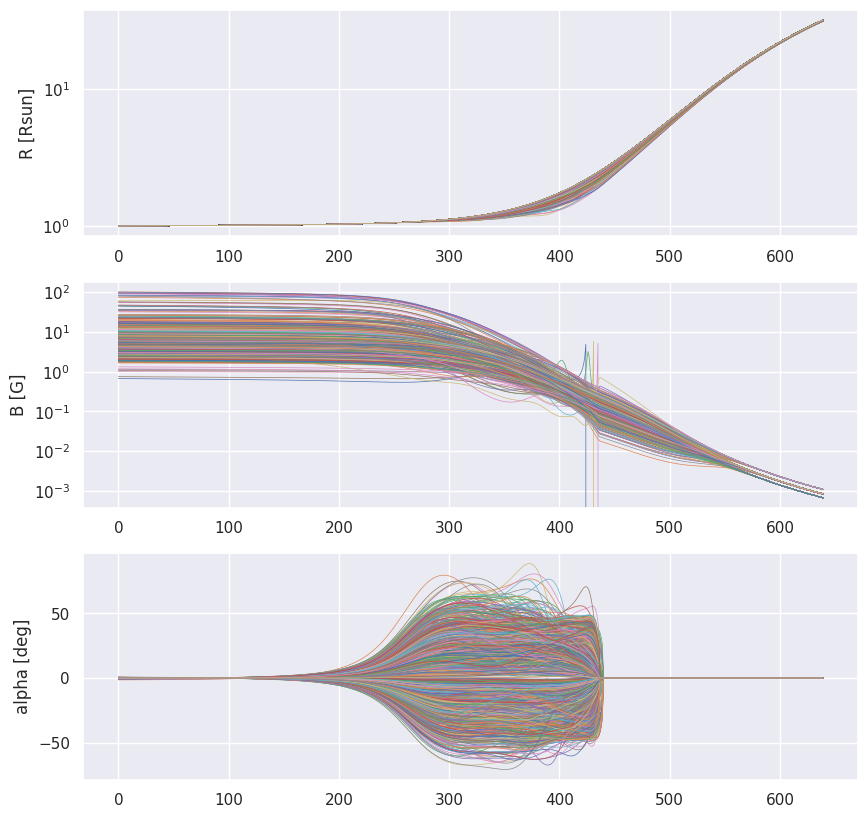

In [4]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for idx, col in enumerate(flow_columns):
    for series in flows_dict.values():
        axs[idx].plot(series.index, series[col], linewidth=0.5)
        
axs[0].set_ylabel('R [Rsun]')
axs[1].set_ylabel('B [G]')
axs[2].set_ylabel('alpha [deg]')

axs[0].set_yscale('log')
axs[1].set_yscale('log')
# axs[2].set_yscale('symlog')


## Scale Inputs

In [5]:
scaled_flows = pd.DataFrame()
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')

for series in flows_dict.values():
    scaled_flows = pd.concat([scaled_flows, series], axis=0)

scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)


scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())
# scaler.fit(scaled_flows)


(754560, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.950074     0.248542
1  0.003003  0.950054     0.248720
2  0.005005  0.950035     0.248900
3  0.007004  0.950016     0.249085
4  0.008863  0.949997     0.249291


# Magnetic Field - B [G]

In [148]:
# separate into file series
scaled_magnetic = [scaled_flows['B [G]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['B [G]']) // 640)]
scaled_magnetic = np.array(scaled_magnetic)
scaled_magnetic[0][:5]


array([0.95007355, 0.95005434, 0.9500351 , 0.95001583, 0.94999652])

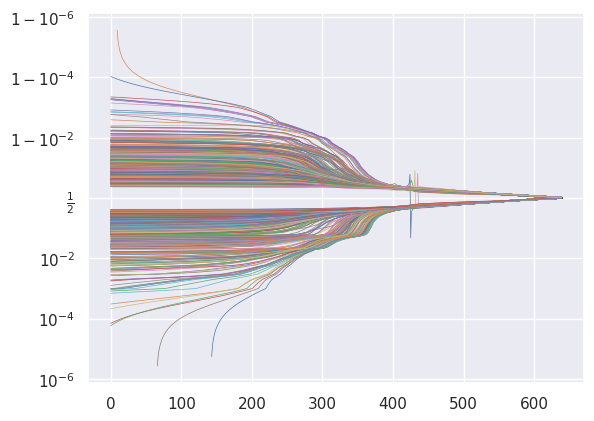

In [149]:
# plot scaled magnetic field
for b_line in scaled_magnetic:
    plt.plot(b_line, linewidth=0.5)

plt.yscale('logit')

## PCA

In [150]:
pca = PCA(n_components=3)
transformed_mag = pca.fit_transform(scaled_magnetic)
transformed_mag

array([[-8.22911573,  0.05430844, -0.10403435],
       [-6.63326414, -0.0439698 , -0.16285523],
       [-5.15917771, -0.51965864,  0.04424125],
       ...,
       [-4.41689209, -0.6703632 ,  0.371676  ],
       [ 8.35062456, -0.28059852,  0.28407249],
       [-7.99713228,  0.02448647, -0.15095622]])

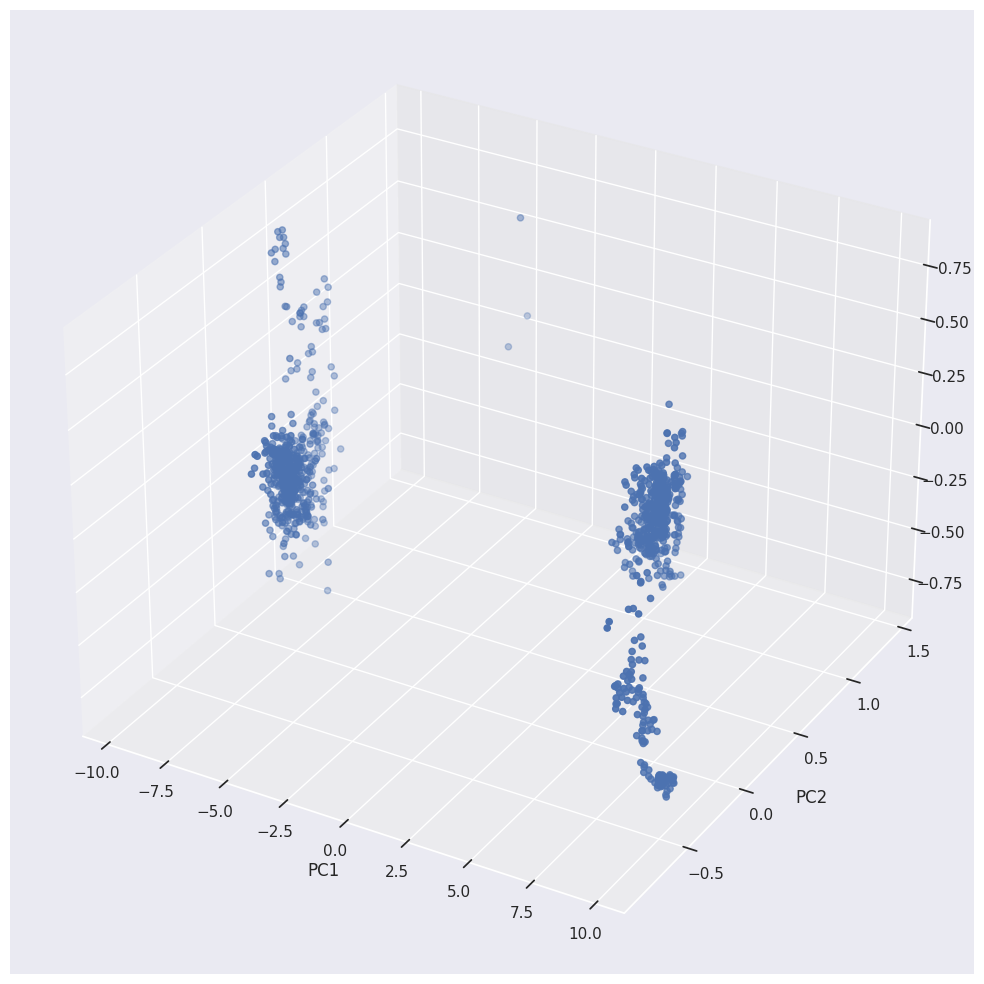

In [20]:
scatter_plot_3d(transformed_mag, color='b')

## K-Means

In [145]:
kmeans = KMeans(n_clusters=2, max_iter=5000, n_init=10)

pca_kmeans_mag_labels = kmeans.fit_predict(transformed_mag)

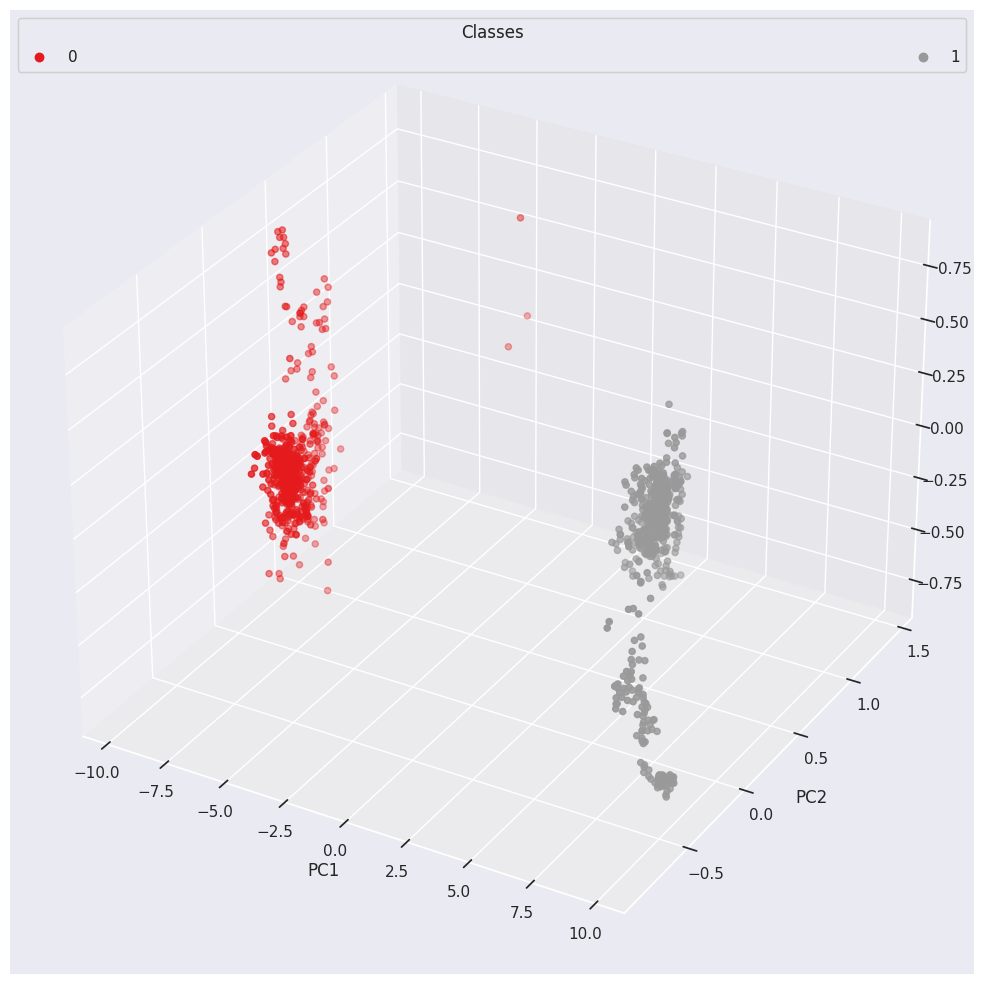

In [146]:
scatter_plot_3d(transformed_mag, c=pca_kmeans_mag_labels, label=pca_kmeans_mag_labels, cmap='Set1')

## Hierarchical Clustering

In [151]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=5, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_mag)

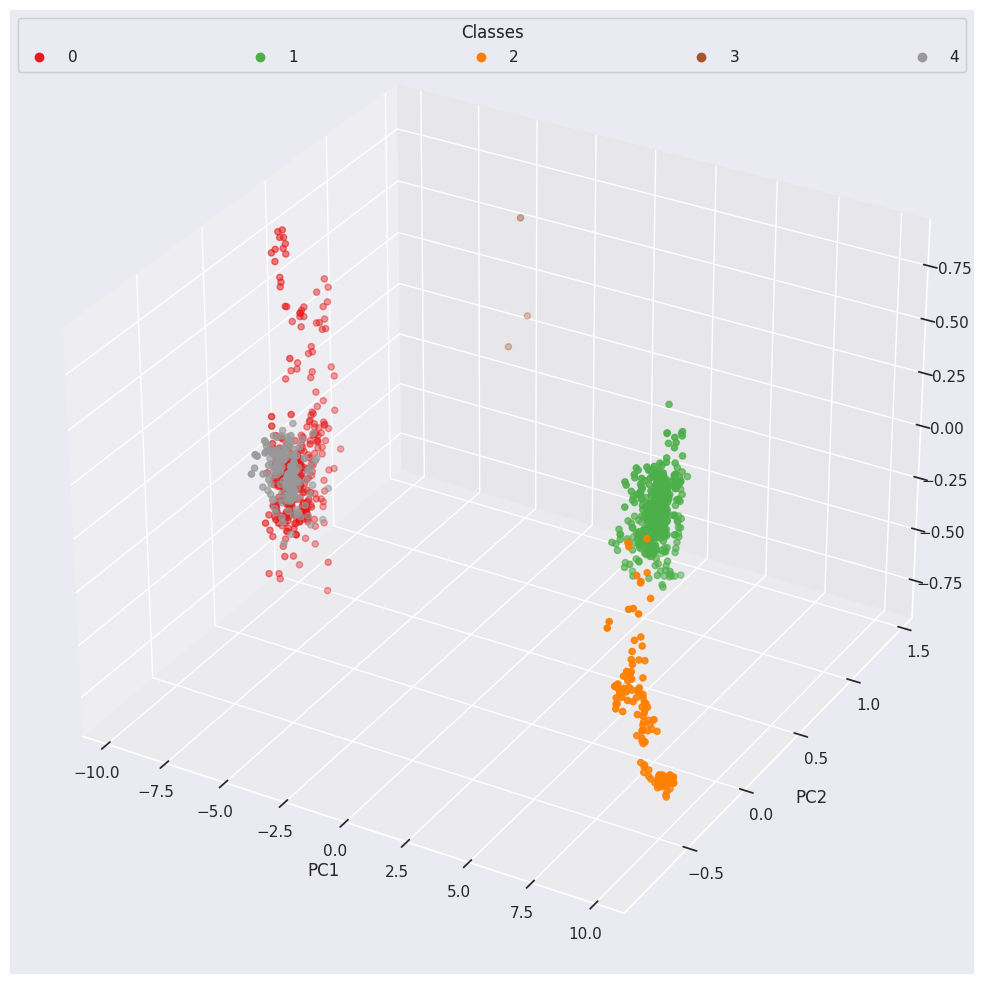

In [152]:
scatter_plot_3d(transformed_mag, c=agg.labels_, cmap='Set1')
# sp.legend_.remove()


### Original Data

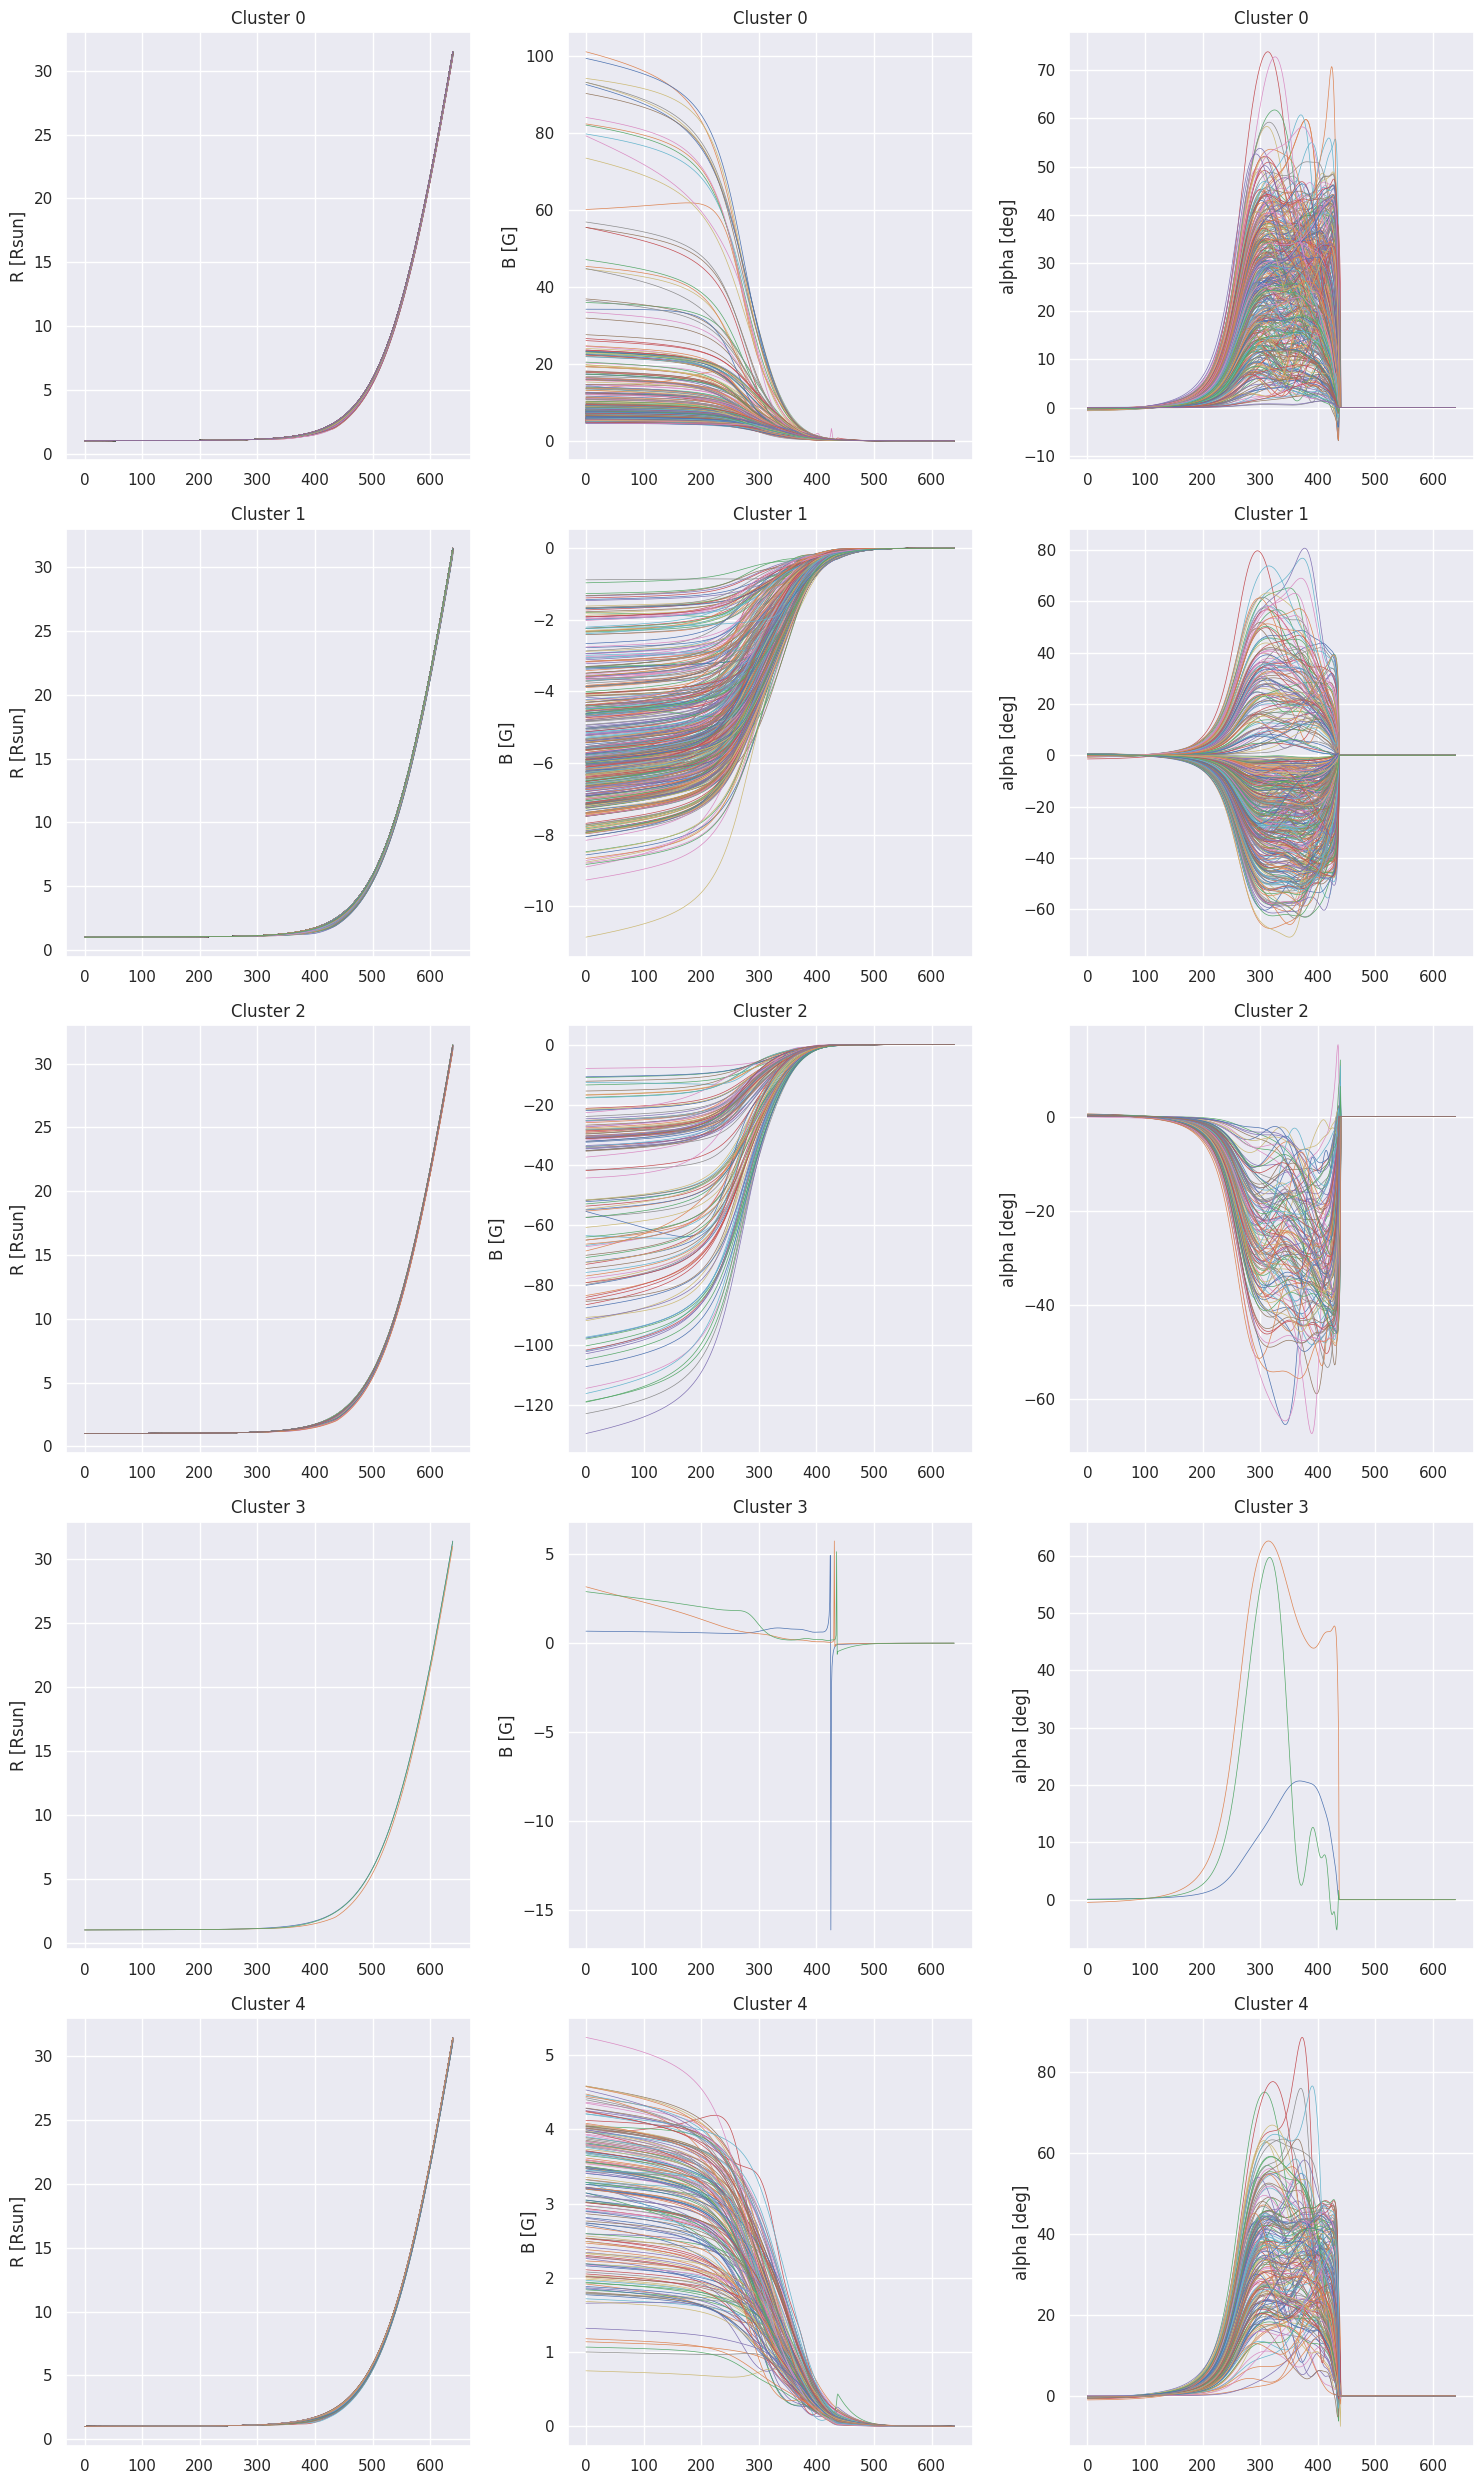

In [153]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns)

In [155]:
%%capture
for i in range(2, 11):
    agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
    agg = agg.fit(transformed_mag)
    
    # sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
    scatter_plot_3d(transformed_mag, c=agg.labels_, cmap='Set1')
    
    sub_dir = OUT_DIR / 'mag'
    if not sub_dir.exists():
        sub_dir.mkdir()
        
    plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
    plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png') 
    

### Cluster Distribution

<AxesSubplot: ylabel='count'>

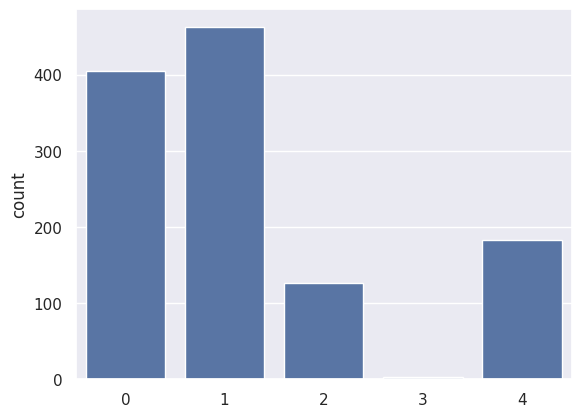

In [154]:
sns.countplot(x=agg.labels_, color='b')

## DBSCAN

In [78]:
dbscan = DBSCAN(eps=0.2, min_samples=6, n_jobs=2, algorithm='auto')
dbscan_mag_labels = dbscan.fit_predict(transformed_mag)

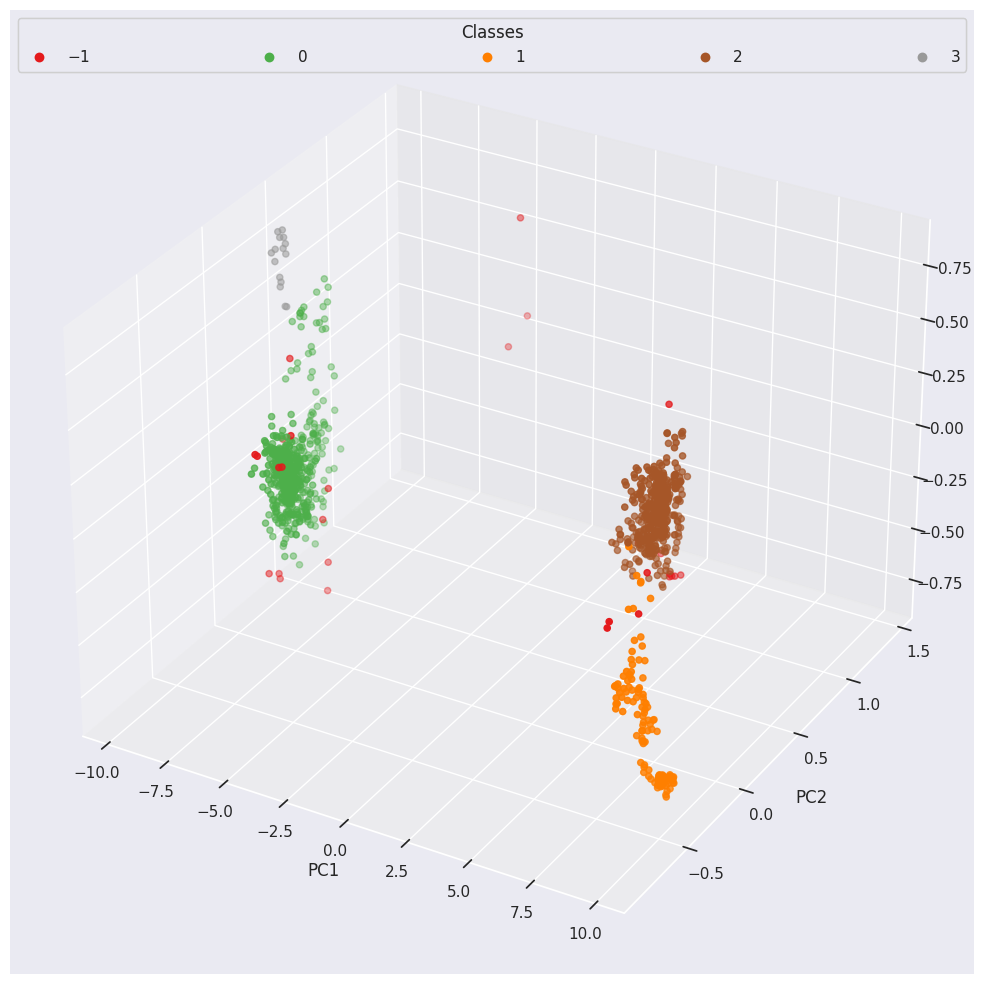

In [79]:
scatter_plot_3d(transformed_mag, c=dbscan_mag_labels, cmap='Set1')

### Original Data

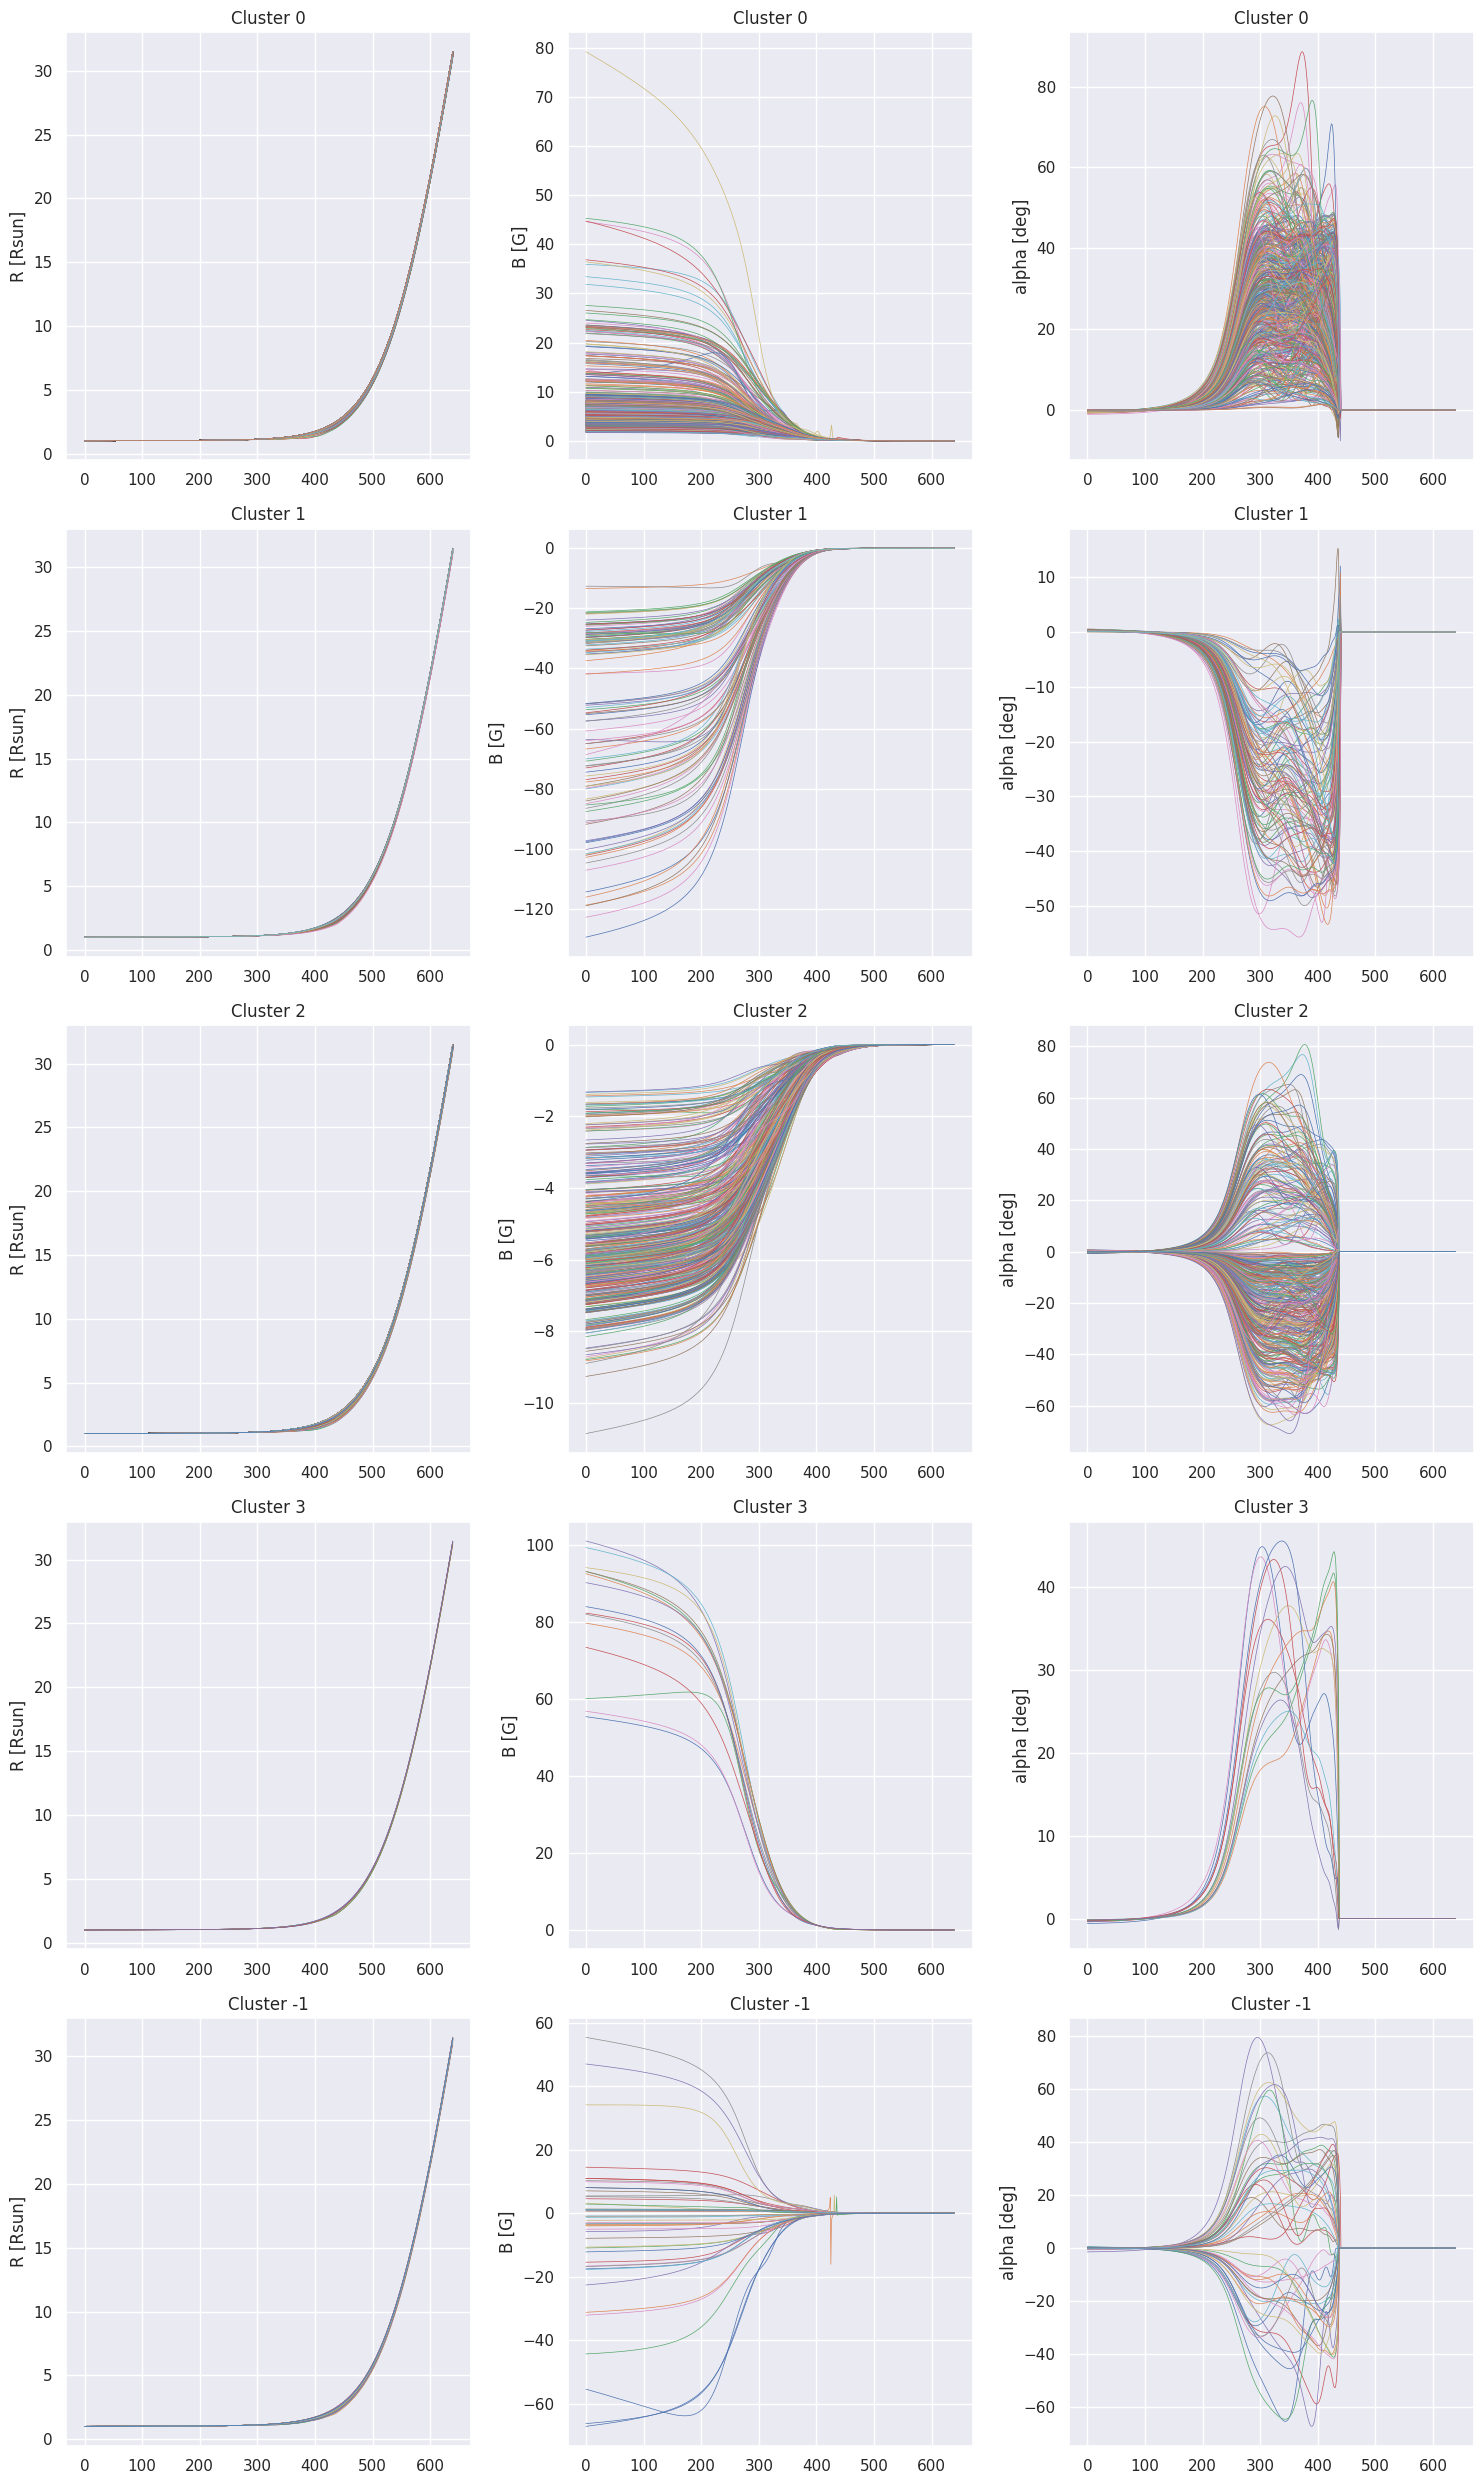

In [77]:
plot_unscaled_clusters(dbscan_mag_labels, len(set(dbscan_mag_labels)), flows_dict, flow_columns)

### Cluster Distribution

<AxesSubplot: ylabel='count'>

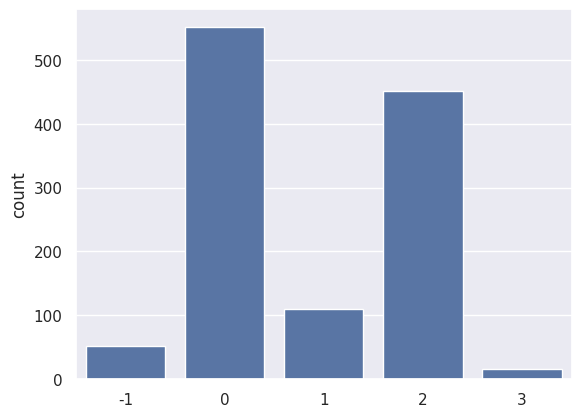

In [62]:
sns.countplot(x=dbscan_mag_labels, color='b')

In [80]:
%%capture

for i in np.arange(0.1, 0.35, 0.05):
    dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
    dbscan_mag_labels = dbscan.fit_predict(transformed_mag)
    
    sub_dir = OUT_DIR / 'mag_dbscan'
    if not sub_dir.exists():
        sub_dir.mkdir()

    save_i = int(i*100)
    scatter_plot_3d(transformed_mag, c=dbscan_mag_labels, cmap='Set1')
    plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
    plot_unscaled_clusters(dbscan_mag_labels, len(set(dbscan_mag_labels)), flows_dict, flow_columns, save_path=sub_dir / f'dbscan_{save_i}.png')
    

# Flux Tube Inclination - alpha [deg]

In [81]:
# separate into file series
scaled_alpha = [scaled_flows['alpha [deg]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['alpha [deg]']) // 640)]
scaled_alpha = np.array(scaled_alpha)
scaled_alpha[0][:5]


array([0.24854238, 0.24871959, 0.24890042, 0.24908493, 0.24929148])

## PCA

In [82]:
pca = PCA(n_components=3)
transformed_alpha = pca.fit_transform(scaled_alpha)
transformed_alpha

array([[-4.55690168e+00,  5.97235259e-01, -2.07260002e-01],
       [-6.35902531e+00,  8.09357718e-01, -8.09345500e-01],
       [-5.61953663e+00, -5.60786088e-01, -7.63166672e-01],
       ...,
       [-5.74487091e+00,  1.20447703e+00,  2.69982931e-01],
       [ 8.22776100e+00, -3.53700676e-01, -2.39997900e-03],
       [-3.04632349e+00, -8.94140827e-01,  8.37732811e-02]])

### Transformed

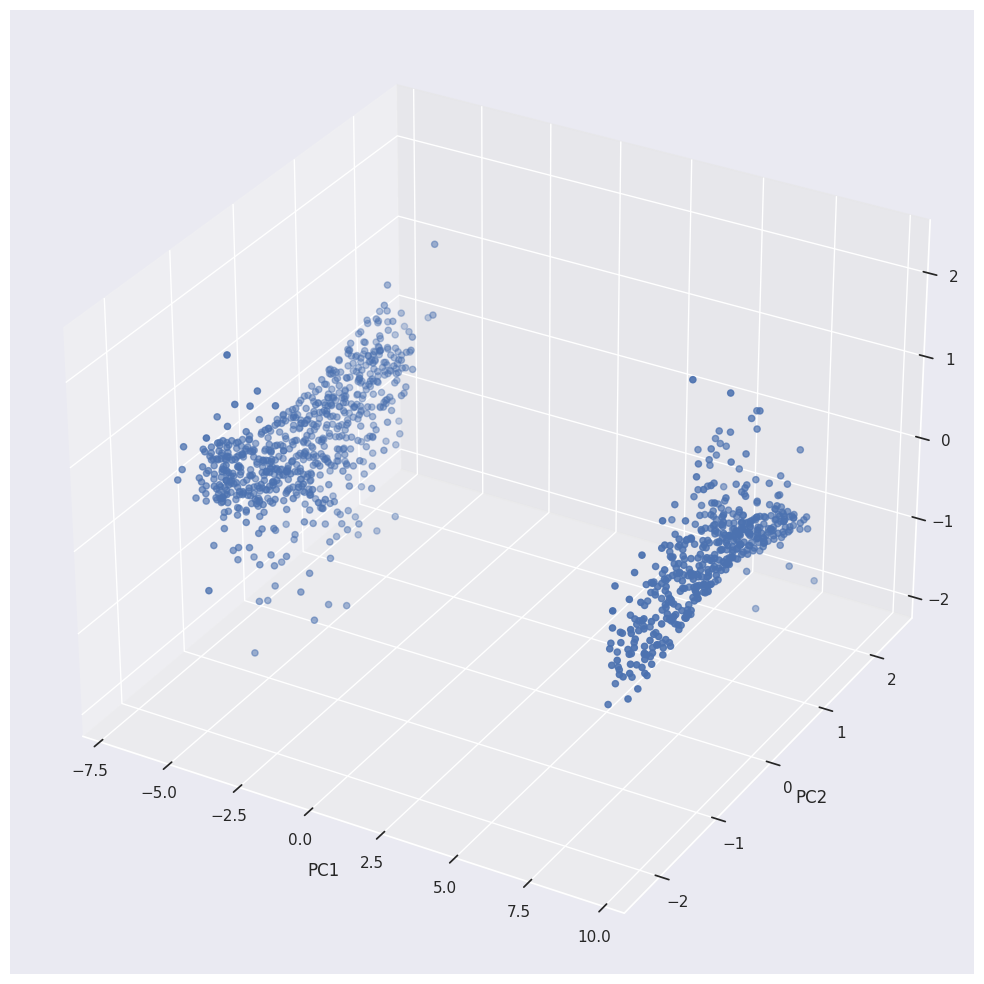

In [96]:
scatter_plot_3d(transformed_alpha, color='b')

## K-Means

In [101]:
kmeans = KMeans(n_clusters=2,max_iter=5000, n_init='auto')

pca_kmeans_alpha_labels = kmeans.fit_predict(transformed_alpha)

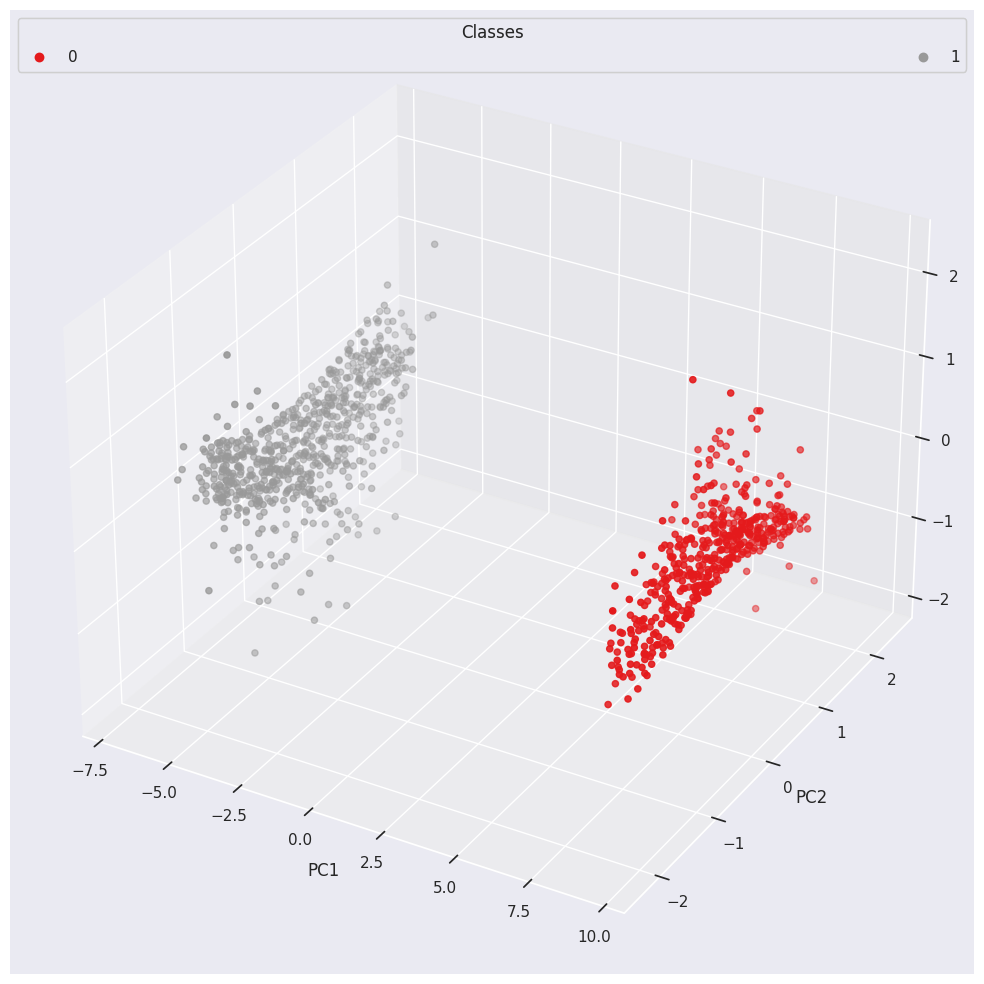

In [102]:
scatter_plot_3d(transformed_alpha, c=pca_kmeans_alpha_labels, cmap='Set1')

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

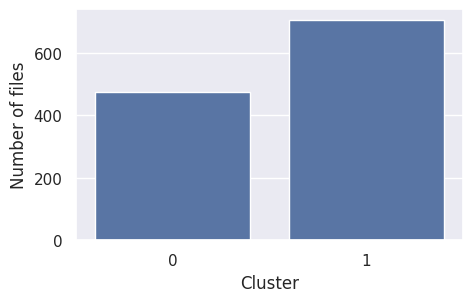

In [103]:
fig, ax = plt.subplots(figsize=(5, 3))
bp = sns.countplot(x=pca_kmeans_alpha_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [119]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=4, compute_full_tree=True, linkage='ward')
agg = agg.fit(transformed_alpha)

Text(0.5, 0, 'Number of points in node')

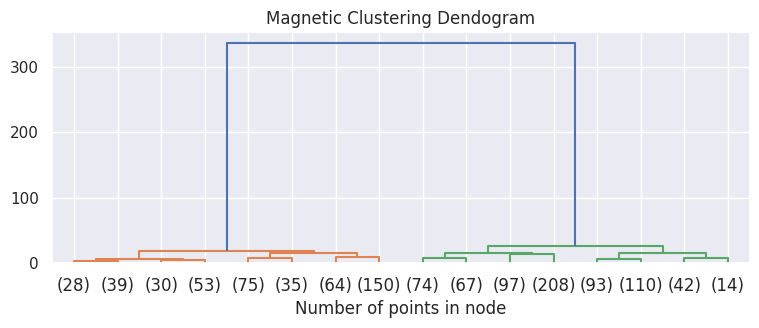

In [120]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

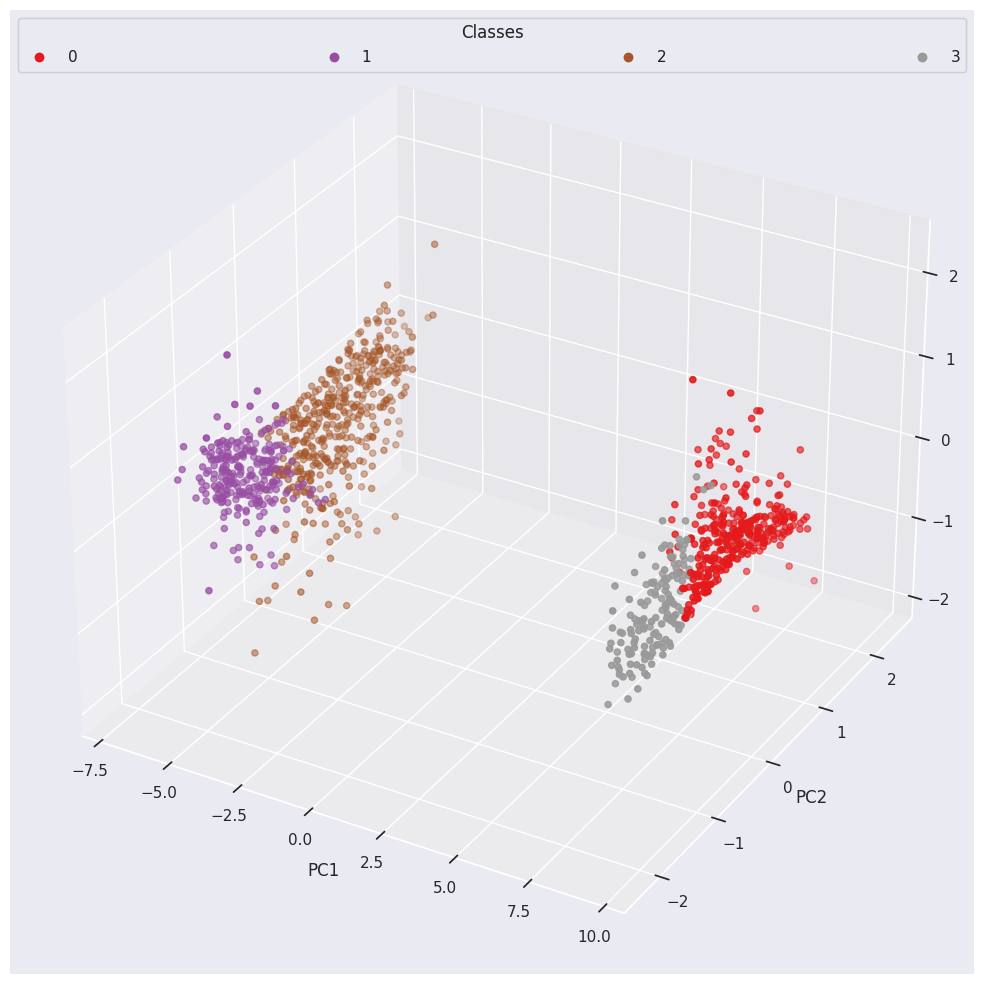

In [121]:
scatter_plot_3d(transformed_alpha, c=agg.labels_, cmap='Set1')

### Original Data

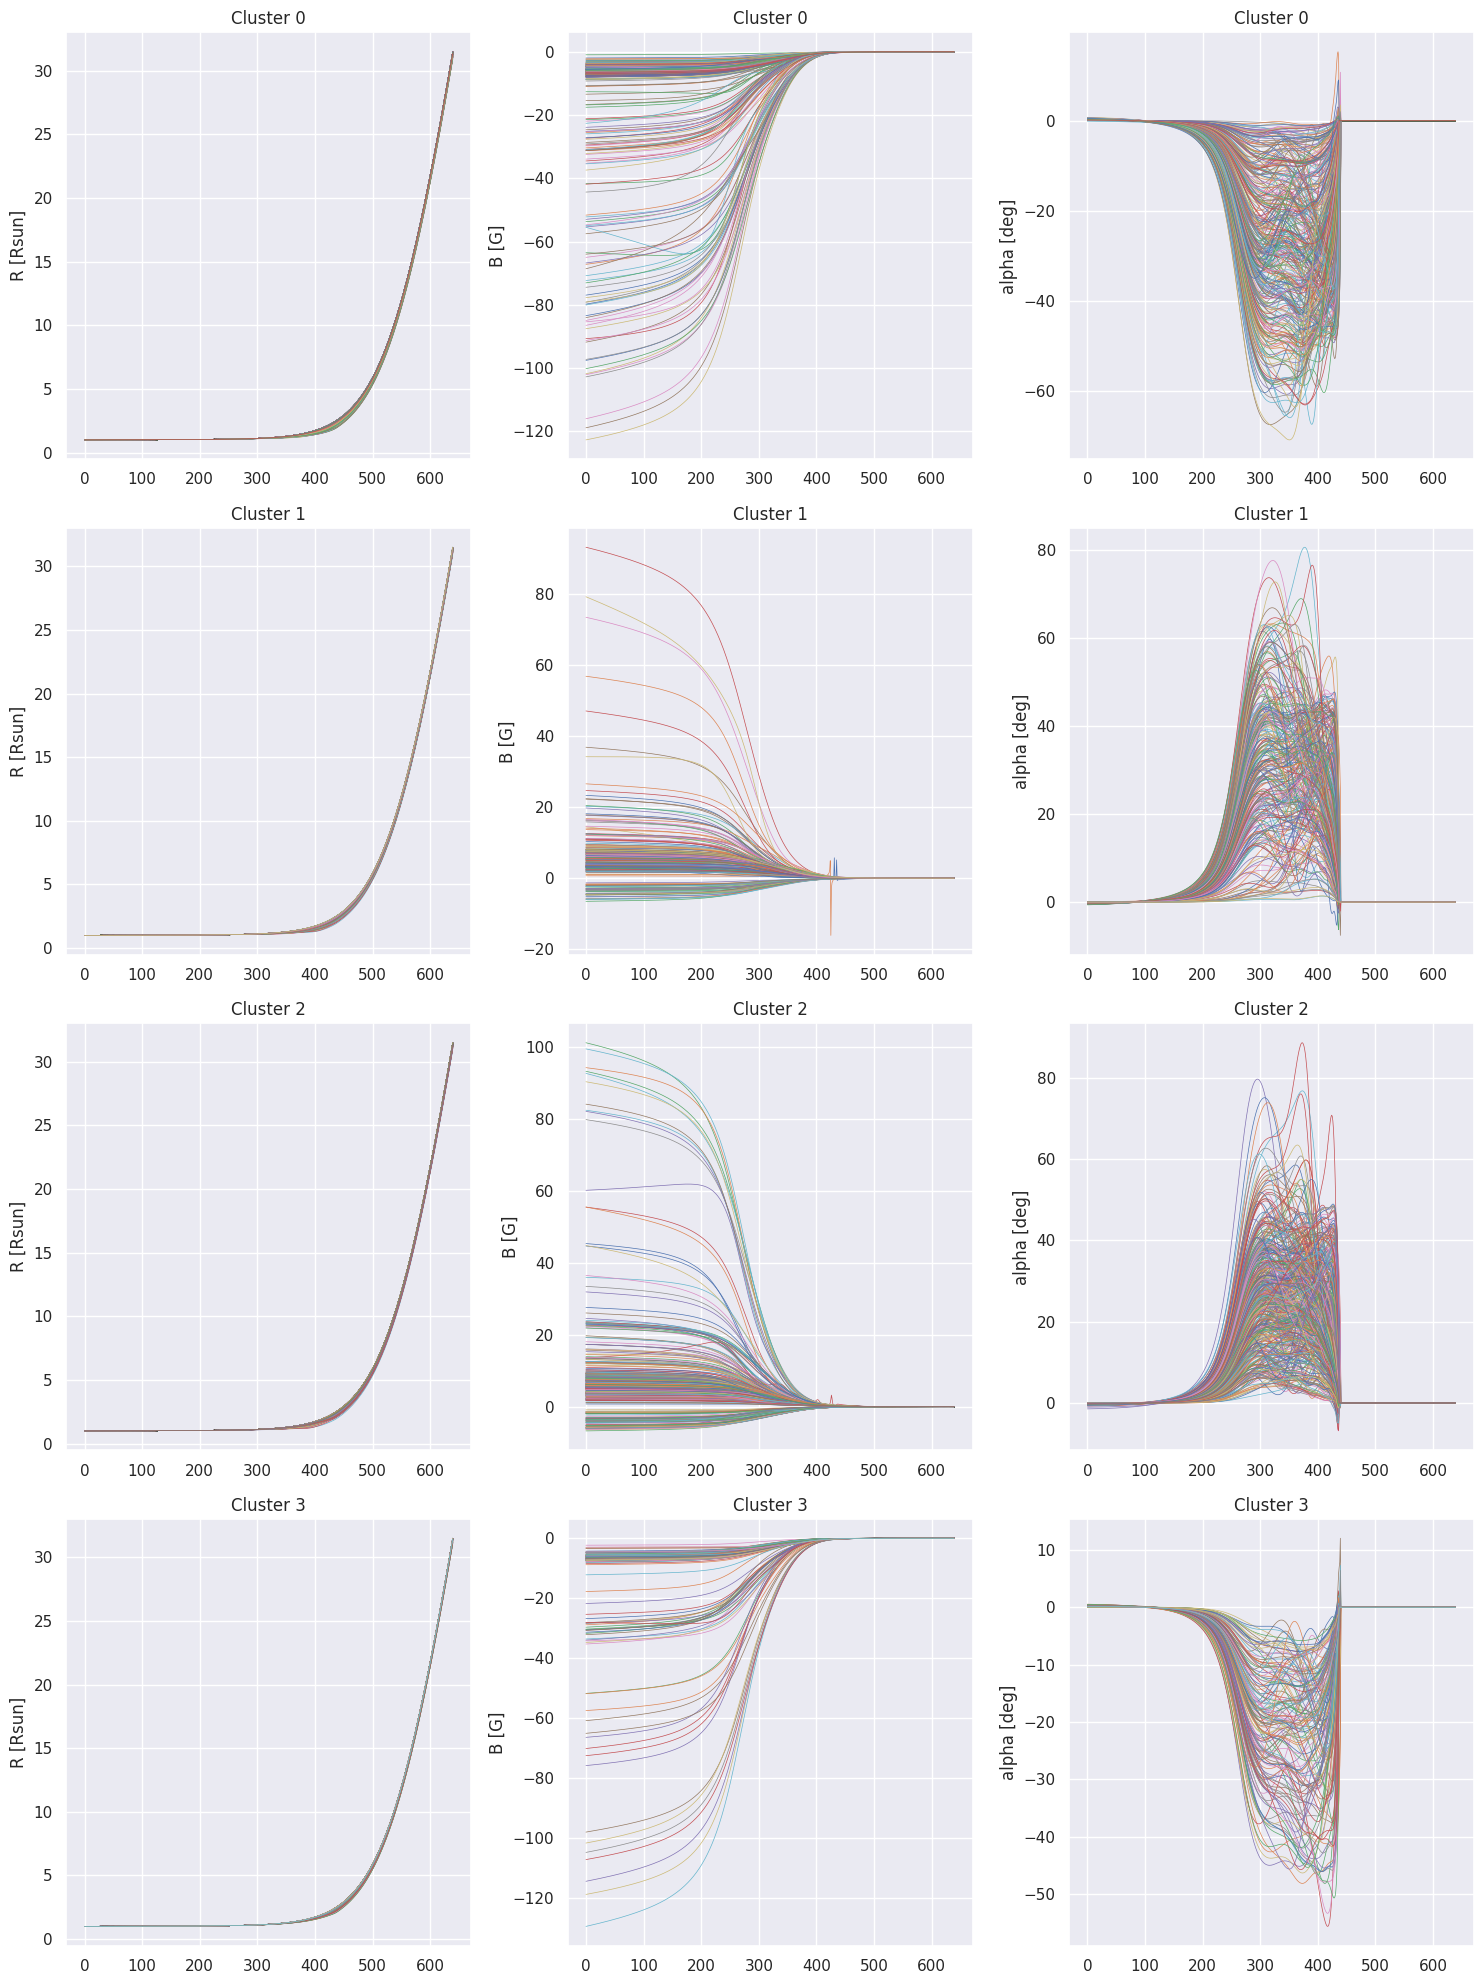

In [122]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns)

### Cluster Distribution

<AxesSubplot: ylabel='count'>

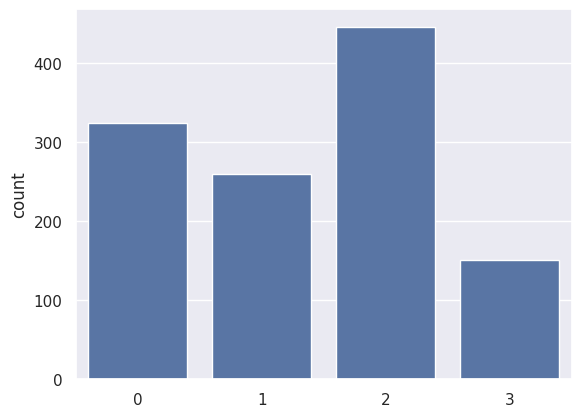

In [123]:
sns.countplot(x=agg.labels_, color='b')

In [112]:
# %%capture
# for i in range(2, 10):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='ward')
#     agg = agg.fit(transformed_alpha)
    
#     scatter_plot_3d(transformed_alpha, c=agg.labels_, cmap='Set1')
    
#     sub_dir = OUT_DIR / 'alpha'
#     if not sub_dir.exists():
#         sub_dir.mkdir()
        
#     plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png') 
    

## DBSCAN

In [131]:
dbscan = DBSCAN(eps=0.25, min_samples=10, n_jobs=2)
dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)

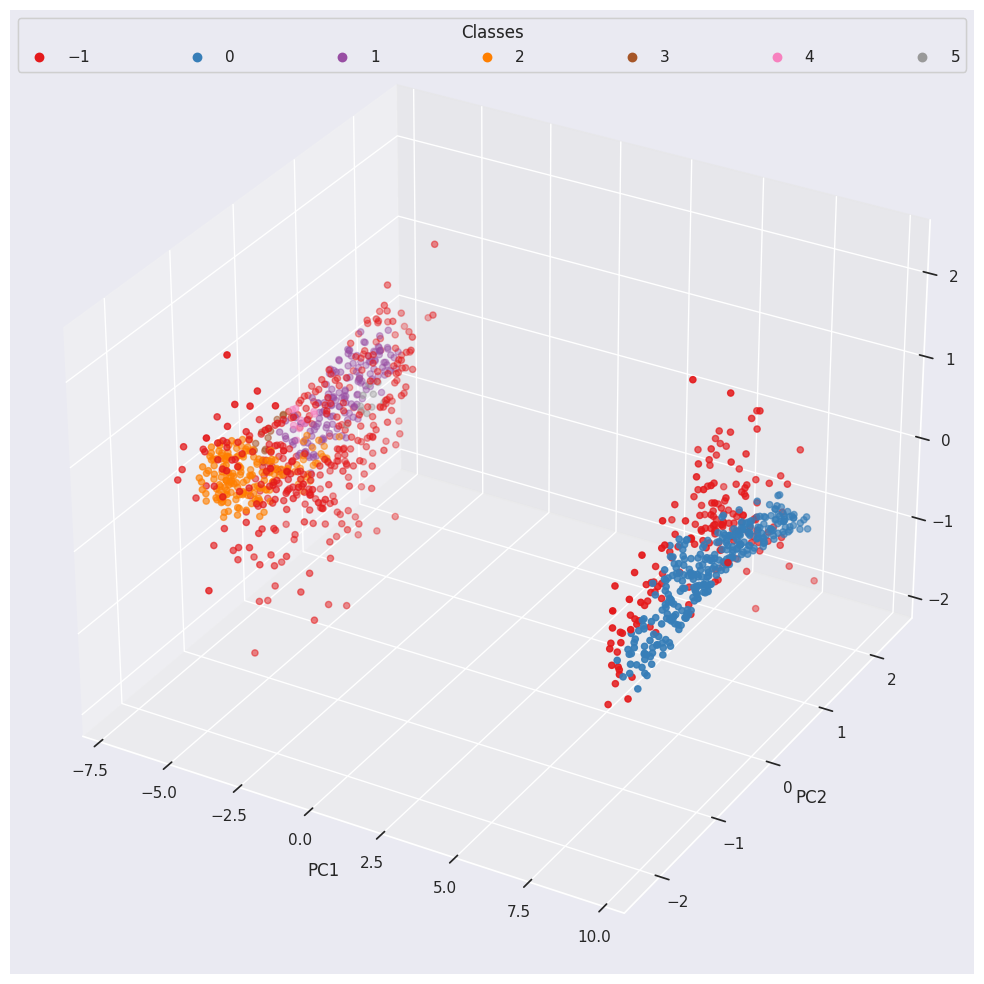

In [132]:
scatter_plot_3d(transformed_alpha, c=dbscan_alpha_labels, cmap='Set1')

### Original Data

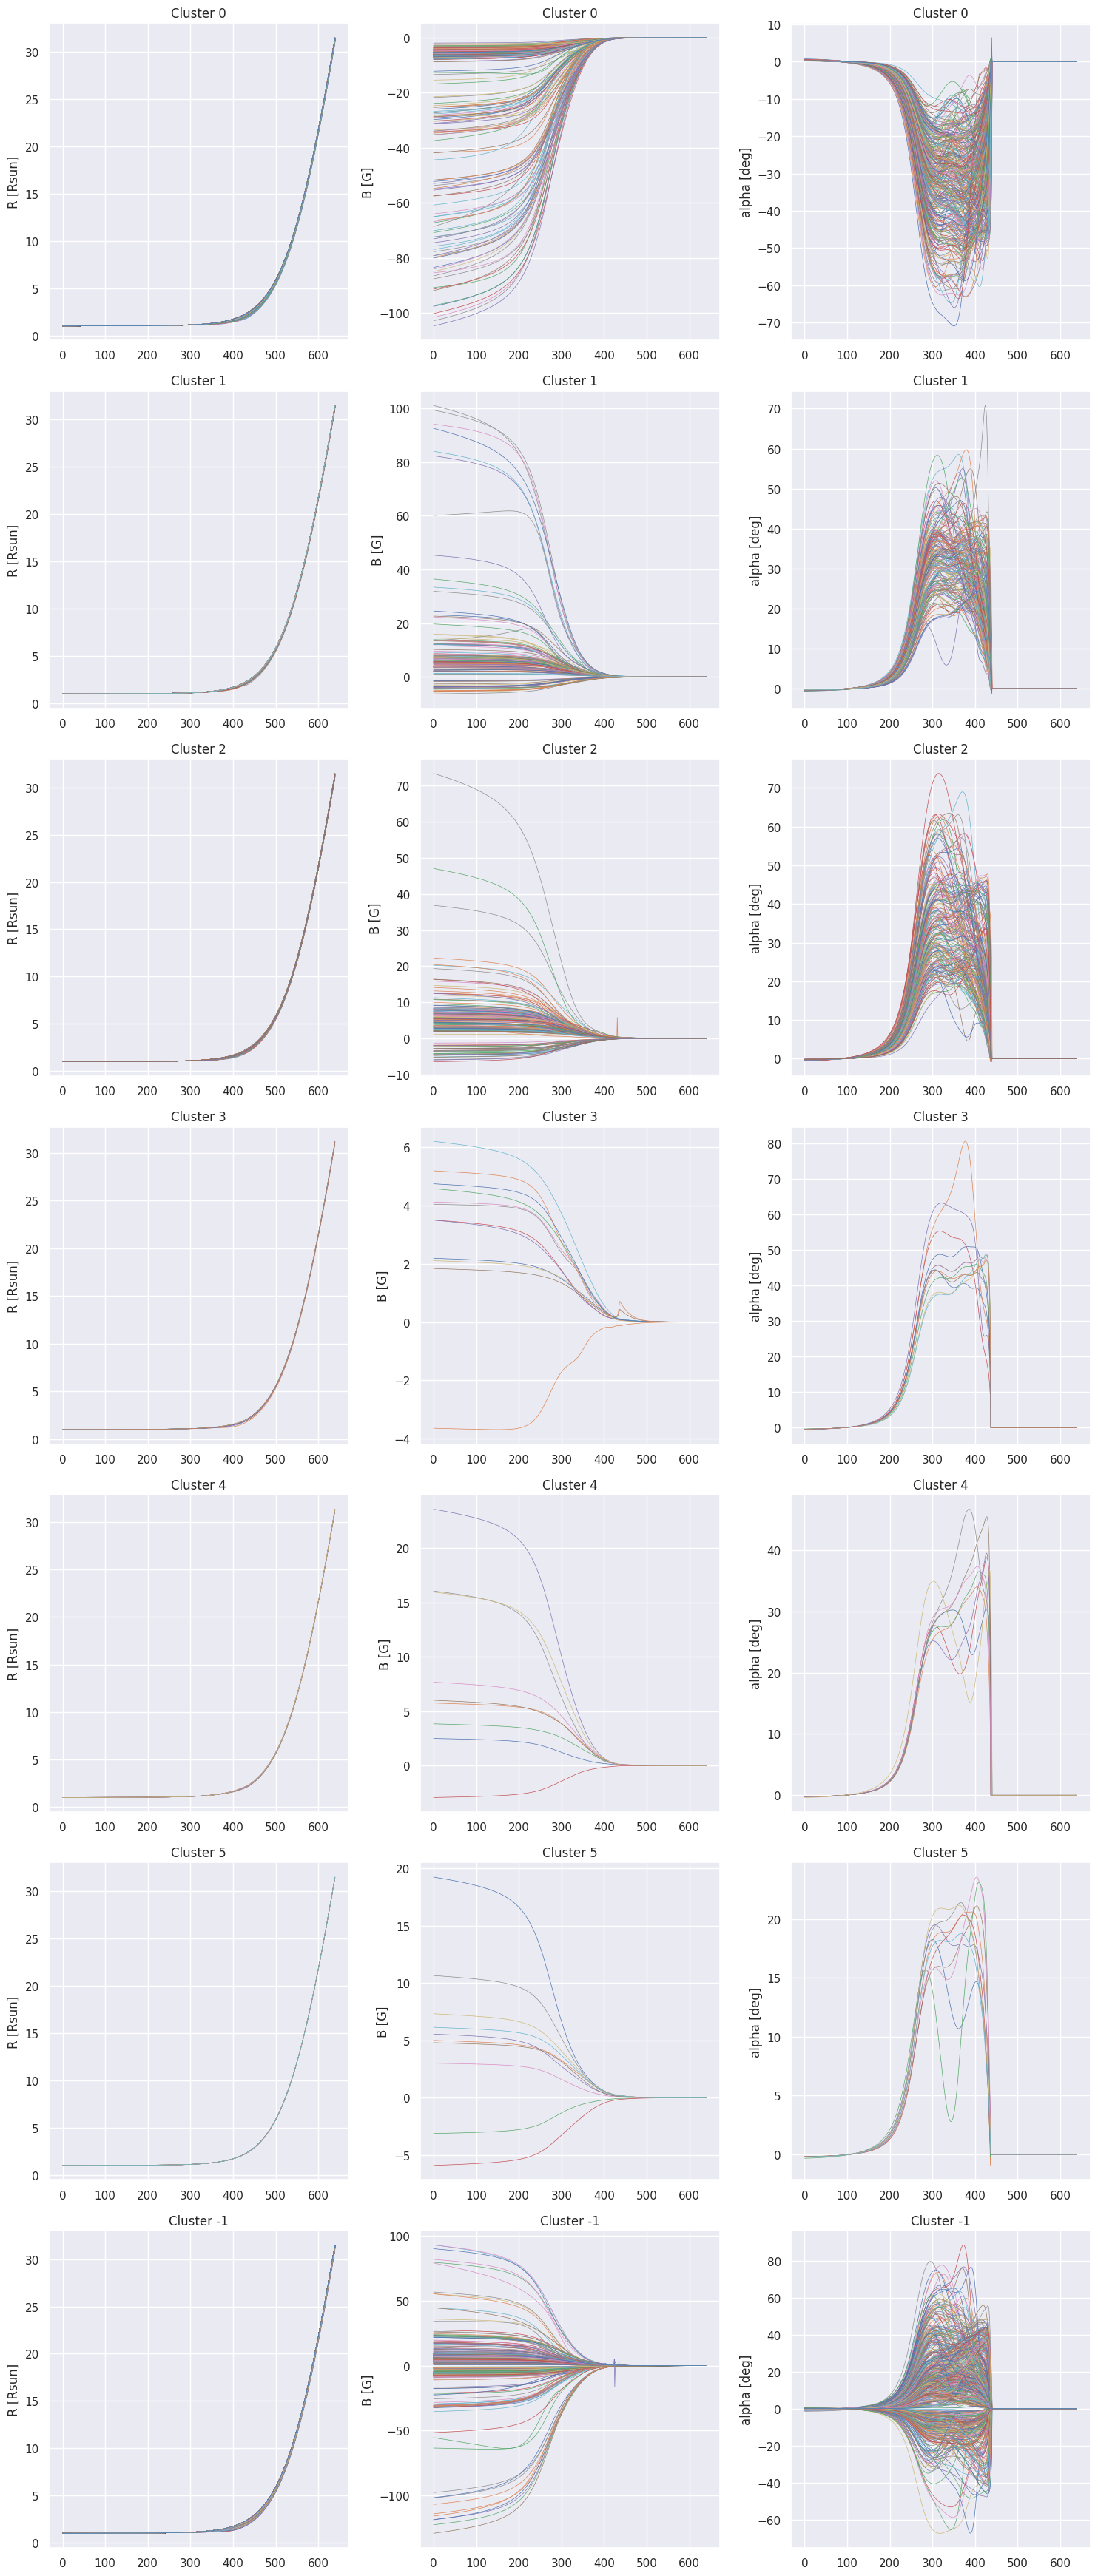

In [133]:
plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns)

### Cluster Distribution

<AxesSubplot: ylabel='count'>

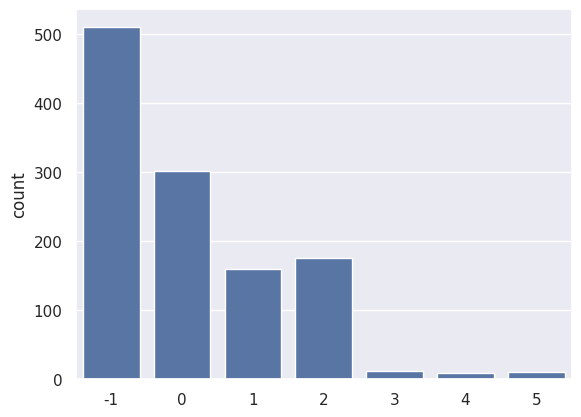

In [127]:
sns.countplot(x=dbscan_alpha_labels, color='b')

In [144]:
%%capture
for i in np.arange(0.25, 0.65, 0.05):
    dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
    dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)
    
    sub_dir = OUT_DIR / 'alpha_dbscan'
    if not sub_dir.exists():
        sub_dir.mkdir()

    save_i = int(round(i, 2) *100)
    scatter_plot_3d(transformed_alpha, c=dbscan_alpha_labels, cmap='Set1')
    plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
    plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns, save_path=sub_dir / f'dbscan_{save_i}.png')
    